In [1]:
!pip install lifelines
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from lifelines import KaplanMeierFitter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=81f4257ce95084389de920fa3c937d672418c7e709d3d9e84499bc43d937cedb
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [5]:
Dset = pd.read_csv('rfm_ecommerce_data.csv')
object_columns = Dset.select_dtypes(include='object').columns
for columnValue in object_columns:
    Dset[columnValue] = Dset[columnValue].astype('category')
    missingVal = Dset.isnull().sum()
print("MissingVal in Col:")
print(missingVal)

MissingVal in Col:
InvoiceNo          0
StockCode          0
Description        0
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID         0
Country            0
date               0
Total              0
recency            0
Frequency          0
Monetary           0
r_quantile         0
f_quantile         0
m_quantile         0
rfm_quantile       0
Segmentation       0
target             0
target_variable    0
dtype: int64


In [4]:
ndf = Dset.drop(columns=['StockCode','Description','Quantity','InvoiceDate','UnitPrice','r_quantile','f_quantile','m_quantile','rfm_quantile','target'])
ndf = ndf.groupby(['InvoiceNo', 'CustomerID', 'Country'], observed=True).agg({
    'Total': 'sum',
    'date': 'first',
    'recency': 'first',
    'Frequency': 'first',
    'Monetary': 'first',
    'Segmentation':'first',
    'target_variable':'first',
}).reset_index()

In [6]:
ndf['date'] = ndf['date'].astype(str)
ndf['date'] = pd.to_datetime(ndf['date'], errors='coerce')

In [7]:
ndf['first_purchase_date'] = ndf.groupby('CustomerID')['date'].transform('min')
ndf['last_purchase_date'] = ndf.groupby('CustomerID')['date'].transform('max')
ndf['tenure'] = (ndf['last_purchase_date'] - ndf['first_purchase_date']).dt.days
ndf['next_purchase_date'] = ndf.groupby('CustomerID')['date'].shift(-1)
ndf['interpurchase_time'] = (ndf['next_purchase_date'] - ndf['date']).dt.days
ndf['average_interpurchase_time'] = ndf.groupby('CustomerID')['interpurchase_time'].transform('mean')

ndf.dropna(subset=['interpurchase_time'], inplace=True)

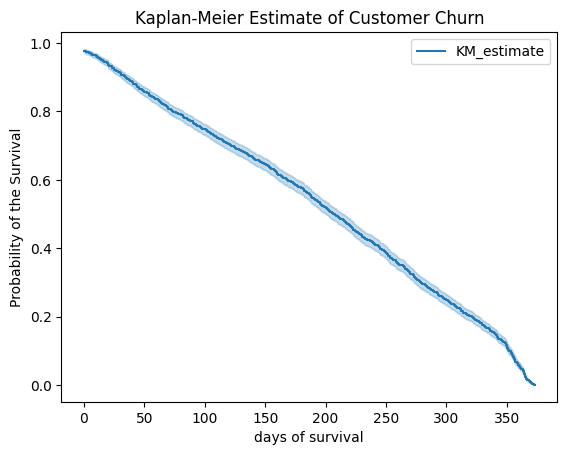

In [9]:
uniqDF = ndf[['CustomerID', 'recency', 'Frequency', 'Monetary', 'Country', 'tenure', 'average_interpurchase_time', 'target_variable']].drop_duplicates()

kplanCurve = KaplanMeierFitter()
kplanCurve.fit(durations=uniqDF['tenure'], event_observed=uniqDF['target_variable'])
kplanCurve.plot_survival_function()
plt.title('Kaplan-Meier Estimate of Customer Churn')
plt.xlabel('days of survival')
plt.ylabel('Probability of the Survival')
plt.show()

ndf['AOV'] = ndf['Monetary'] / ndf['Frequency']

uniqDF = ndf[['CustomerID', 'recency', 'Frequency', 'Monetary', 'Country', 'tenure', 'average_interpurchase_time', 'target_variable', 'AOV']].drop_duplicates()


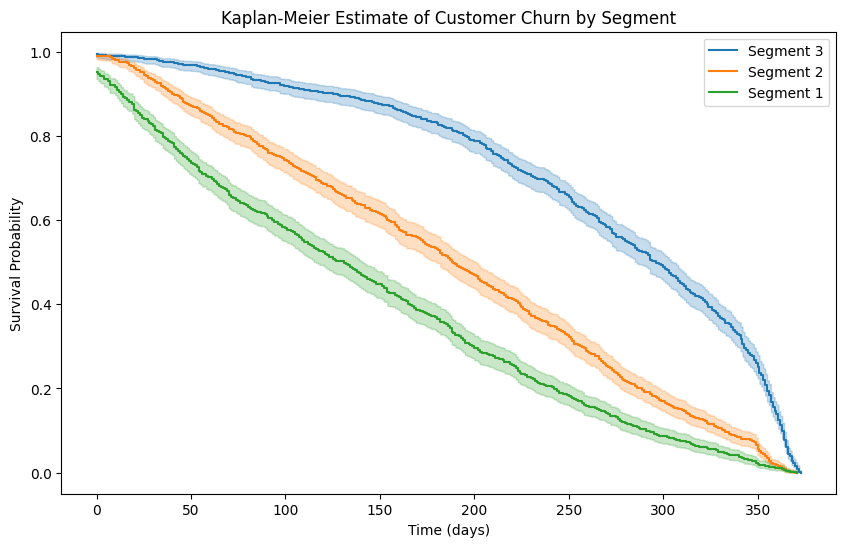

In [11]:
ndf['AOV'] = ndf['Monetary'] / ndf['Frequency']

uniqDF = ndf[['CustomerID', 'recency', 'Frequency', 'Monetary', 'Country', 'tenure', 'average_interpurchase_time', 'target_variable', 'AOV']].drop_duplicates()

median_customer_lifetime = kplanCurve.median_survival_time_
clv = median_customer_lifetime * uniqDF['AOV'] * uniqDF['Frequency']
uniqDF['CLV'] = clv
uniqDF['rfm_quantile'] = uniqDF[['recency', 'Frequency', 'Monetary']].sum(axis=1)
uniqDF['rfm_quantile'] = pd.qcut(uniqDF['rfm_quantile'], q=3, labels=[1, 2, 3])

plt.figure(figsize=(10, 6))

for label in uniqDF['rfm_quantile'].unique():
    segment = uniqDF[uniqDF['rfm_quantile'] == label]
    kplanCurve.fit(durations=segment['tenure'], event_observed=segment['target_variable'], label=f'Segment {label}')
    kplanCurve.plot_survival_function()

plt.title('Kaplan-Meier Estimate of Customer Churn by Segment')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

In [13]:
X = ndf[['recency', 'Frequency', 'Monetary', 'Country', 'tenure', 'interpurchase_time']]
y = ndf['target_variable'] - 1
X = pd.get_dummies(X, columns=['Country'], drop_first=True)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

models = {
    "LR": LogisticRegression(max_iter=200, random_state=42),
    "DT": DecisionTreeClassifier(random_state=42),
    "RF": RandomForestClassifier(random_state=42),
    "XGB": xgb.XGBClassifier(eval_metric='logloss', random_state=42)
}

smote = SMOTE(random_state=42)

scores = {model: {'accur': [], 'prec': [], 'reCal': [], 'f1': [], 'spec': []} for model in models.keys()}

def spec_score(y_t, y_p):
    t_n, f_p, f_n, t_p = confusion_matrix(y_t, y_p).ravel()
    return t_n / (t_n + f_p)

for tr_ind, te_ind in kf.split(X):
    Xtrain, Xtest = X.iloc[tr_ind], X.iloc[te_ind]
    Ytrain, Ytest = y.iloc[tr_ind], y.iloc[te_ind]
    Xtrain_resampled, Ytrain_resampled = smote.fit_resample(Xtrain, Ytrain)

    for MLname, model in models.items():
        model.fit(Xtrain_resampled, Ytrain_resampled)
        y_p = model.predict(Xtest)
        scores[MLname]['accur'].append(accuracy_score(Ytest, y_p))
        scores[MLname]['prec'].append(precision_score(Ytest, y_p, average='macro'))
        scores[MLname]['reCal'].append(recall_score(Ytest, y_p, average='macro'))
        scores[MLname]['f1'].append(f1_score(Ytest, y_p, average='macro'))
        scores[MLname]['spec'].append(spec_score(Ytest, y_p))

for MLname, MLscores in scores.items():
    print(f"{MLname} outcomes:")
    print(f"avg accuracy score using cross-validation: {np.mean(MLscores['accur']):.4f}")
    print(f"avg precision score using cross-validation: {np.mean(MLscores['prec']):.4f}")
    print(f"avg recall score using cross-validation: {np.mean(MLscores['reCal']):.4f}")
    print(f"avg F1 score using cross-validation: {np.mean(MLscores['f1']):.4f}")
    print(f"avg specificity score using cross-validation: {np.mean(MLscores['spec']):.4f}")
    print("\n")

LR outcomes:
avg accuracy score using cross-validation: 0.9909
avg precision score using cross-validation: 0.7083
avg recall score using cross-validation: 0.9814
avg F1 score using cross-validation: 0.7861
avg specificity score using cross-validation: 0.9717


DT outcomes:
avg accuracy score using cross-validation: 0.9999
avg precision score using cross-validation: 0.9999
avg recall score using cross-validation: 0.9825
avg F1 score using cross-validation: 0.9902
avg specificity score using cross-validation: 0.9650


RF outcomes:
avg accuracy score using cross-validation: 0.9999
avg precision score using cross-validation: 0.9999
avg recall score using cross-validation: 0.9908
avg F1 score using cross-validation: 0.9952
avg specificity score using cross-validation: 0.9817


XGB outcomes:
avg accuracy score using cross-validation: 0.9994
avg precision score using cross-validation: 0.9690
avg recall score using cross-validation: 0.9865
avg F1 score using cross-validation: 0.9763
avg specif